In [1]:
!nvidia-smi

Tue Mar 14 12:16:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.50       Driver Version: 472.50       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    13W / 320W |    162MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Settings

In [2]:
# 필요 모델 호출
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
import random
import tensorflow as tf

In [3]:
def seed_everything(seed: int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
class config:
    seed = 2022

In [5]:
seed_everything(config.seed)
# seed = 2022
# tf.random.set_seed(seed)

# Load Dataset

In [6]:
# 이미지 로드
imglist = os.listdir('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/')
def load_image(path):
    image_list = np.zeros((len(imglist), 128, 128))
    for i in range(len(imglist)):
        img = Image.open('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/'+str(imglist[i])).convert('L')
        image_list[i] = img
    return image_list

In [7]:
posi = load_image('/Users/User/303/COVID-19_Radiography_Dataset/COID/images/*.png')
posi = posi.astype('float32')/255.
print(posi.shape)

(3616, 128, 128)


# Train Validation Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_trainval, x_test = train_test_split(posi, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(X_trainval, train_size=0.75, random_state=42)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2169, 128, 128)
(723, 128, 128)
(724, 128, 128)


In [10]:
# def train_test_split(img):
#     rnd = np.random.RandomState(seed=51)
#     perm = rnd.permutation(len(img))
#     train_idx = perm[:int(0.8 * len(img))]
#     test_idx = perm[int(0.8 * len(img)):]
#     return img[train_idx], img[test_idx]

# x_train, x_test = train_test_split(posi)
# print(x_train.shape, x_test.shape)

# Noise

In [11]:
def noisy(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        return noisy
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[tuple(coords)] = 0
        return out

    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        return noisy
    # Poisson Noisy
    elif noise_typ == "poisson":
        
        noisy = image + 0.1 *  np.random.poisson(lam=1.0,size=image.shape)
        return noisy

In [12]:
def MAE(img1, img2):
    D = np.array(img1 - img2, dtype=np.float64)
    D[:, :] = np.abs(D[:, :])
    MAE = D.sum()/img1.size
    return MAE

def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [13]:
from skimage.restoration import denoise_nl_means, denoise_bilateral
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.util import random_noise

def Meanfilter(noisy_test_data):
    meanfilter = []
    for i in range(len(noisy_test_data)):
         meanfilter.append(cv2.blur(noisy_test_data[i],(3,3)))
    meanfilter = np.array(meanfilter)
    return meanfilter
    
def Medianfilter(noisy_test_data):
    medianfilter = []
    for i in range(len(noisy_test_data)):
        medianfilter.append(medfilt2d(noisy_test_data[i],(3,3)))
    medianfilter = np.array(medianfilter)
    return medianfilter


def lee_filter(img):
    lee = []
    for i in range(len(img)):
        img_mean = uniform_filter(img[i])
        img_sqr_mean = uniform_filter(img[i]**2)
        img_variance = img_sqr_mean - img_mean**2
        
        overall_variance = variance(img[i])
        
        img_weights = (img_variance**2) / ((img_variance**2) + (overall_variance**2))
        img_output = img_mean + img_weights * (img[i] - img_mean)
        
        lee.append(img_output)
    lee = np.array(lee)
    return lee

In [14]:
# Add Noisy
x_train_sp_noisy = noisy("gauss",x_train)
x_val_sp_noisy = noisy("gauss",x_val)

x_test_sp_noisy = noisy("gauss",x_test)

x_train_sp_noisy=x_train_sp_noisy.clip(0,1)
x_val_sp_noisy=x_val_sp_noisy.clip(0,1)

x_test_sp_noisy=x_test_sp_noisy.clip(0,1)
x_train_sp_noisy[0]

array([[0.03524133, 0.        , 0.00960086, ..., 0.        , 0.        ,
        0.25569832],
       [0.18966787, 0.        , 0.16422461, ..., 0.01901354, 0.06006142,
        0.08837302],
       [0.        , 0.        , 0.01300827, ..., 0.00696893, 0.        ,
        0.03027531],
       ...,
       [0.        , 0.        , 0.04523663, ..., 0.11358681, 0.17416708,
        0.        ],
       [0.        , 0.15981305, 0.        , ..., 0.02382187, 0.        ,
        0.03555864],
       [0.        , 0.12773165, 0.0765071 , ..., 0.08724136, 0.04675634,
        0.        ]])

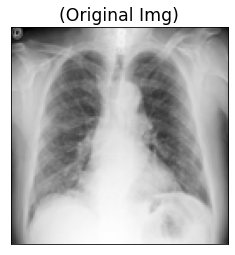

In [15]:
# Original Image
ax = plt.subplot()
plt.imshow(x_test[5], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Original Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

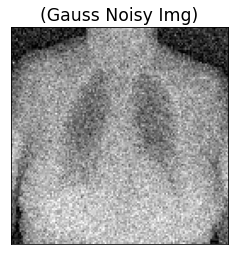

In [16]:
# Salt & Pepper Noisy Image
ax = plt.subplot()
plt.imshow(x_test_sp_noisy[1], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.06248664855957031


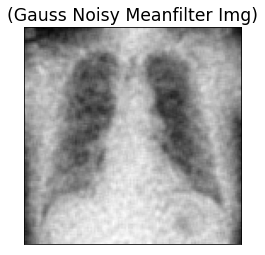

In [17]:
# MeanFilter Image
start = time.time()
mean_x_test_sp_noisy = Meanfilter(x_test_sp_noisy)
end = time.time()
Meantime= end - start
print("CPU 시간 : "+str(Meantime))

ax = plt.subplot()
plt.imshow(mean_x_test_sp_noisy[5], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Meanfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.9216628074645996


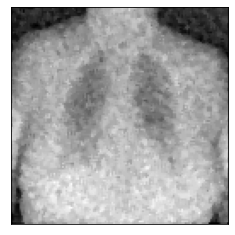

In [18]:
# MedianFilter Image
start = time.time()
median_x_test_sp_noisy = Medianfilter(x_test_sp_noisy)
end = time.time()
Mediantime= end - start
print("CPU 시간 : "+str(Mediantime))

ax = plt.subplot()
plt.imshow(median_x_test_sp_noisy[1], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [19]:
# bilateral_x_test_sp_noisy=[]
# for i in range(len(x_test_sp_noisy)):
#     #img=denoise_bilateral(x_test_sp_noisy[i], sigma_spatial=.5)
#     src =x_test_sp_noisy[i]
#     src =np.array(src)
#     src =np.float32(src)
#     img=cv2.bilateralFilter(src, d=-1, sigmaColor=0.26, sigmaSpace=2)
    
#     bilateral_x_test_sp_noisy= np.append(bilateral_x_test_sp_noisy,img)
#     bilateral_x_test_sp_noisy =np.array(bilateral_x_test_sp_noisy)

# bilateral_x_test_sp_noisy = bilateral_x_test_sp_noisy.reshape(len(x_test_sp_noisy),128,128)
# bilateral_x_test_sp_noisy =bilateral_x_test_sp_noisy.astype('float32')
# print(bilateral_x_test_sp_noisy.shape)
# plt.imshow(bilateral_x_test_sp_noisy[1],cmap='gray')
# plt.title("(Gauss Noisy Bilateral Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
# plt.show()

In [20]:
# src =x_test_sp_noisy[101]
# src =np.array(src)
# src =np.float32(src)
# #img=cv2.bilateralFilter(src, d=-1, sigmaColor=0.22, sigmaSpace=2) #best
# img=cv2.bilateralFilter(src, d=-1, sigmaColor=0.26, sigmaSpace=2)

# print(PSNR(x_test[101],img))
# print(ssim(x_test[101],img))
# plt.imshow(img,cmap='gray')

In [21]:
# nlmeans_x_test_sp_noisy=[]
# #5 ,3, 0.1 ->psnr30
# for i in range(len(x_test_sp_noisy)):
#     #img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 10, patch_distance =3, h = 0.1, fast_mode=False ,sigma =0.0 )
#     #src =x_test_sp_noisy[i]
#     #src = (src * 255).astype('uint8')
#     img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 9, patch_distance =25, h = 0.1, fast_mode=False ,sigma =0.0 )
#     #img = img.astype('float32')/255.
#     nlmeans_x_test_sp_noisy= np.append(nlmeans_x_test_sp_noisy,img)
#     nlmeans_x_test_sp_noisy =np.array(nlmeans_x_test_sp_noisy)

# nlmeans_x_test_sp_noisy = nlmeans_x_test_sp_noisy.reshape(len(x_test_sp_noisy),128,128)
# nlmeans_x_test_sp_noisy =nlmeans_x_test_sp_noisy.astype('float32')
# print(nlmeans_x_test_sp_noisy.shape)
# plt.imshow(nlmeans_x_test_sp_noisy[1],cmap='gray')
# plt.title("(Gauss Noisy NL Means Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
# plt.show()

In [22]:
# #src =x_test_sp_noisy[1]
# #src = (src * 255).astype('uint8')
# #img =cv2.fastNlMeansDenoising(src,h=0.01,templateWindowSize=3, searchWindowSize=3)
# img=denoise_nl_means(x_test_sp_noisy[5], patch_size = 9, patch_distance =25, h = 0.1, fast_mode=False ,sigma =0.0 )
# #img = img.astype('float32')/255.
# print(img)
# print(PSNR(x_test[5],img))
# print(ssim(x_test[5],img))
# plt.imshow(img,cmap='gray')

In [23]:
# def diffusivity_function(g, alpha=10):
#     return 1 / (1 + (g / alpha) ** 2)

# def anisotropic_diffusion(image, num_iterations=10, delta_t=0.25):
#     # Convert the image to grayscale
#     if len(image.shape) > 2:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Set up the diffusion coefficient function
#     diffusivity = diffusivity_function

#     # Apply the diffusion equation
#     u = np.float32(image)
#     for i in range(num_iterations):
#         # Calculate the gradient of the image
#         grad = np.gradient(u)
#         norm = np.sqrt(grad[0] ** 2 + grad[1] ** 2)

#         # Calculate the diffusivity function
#         diff = diffusivity(norm)

#         # Apply the diffusion equation
#         u = u + delta_t * diff * (grad[0] ** 2 + grad[1] ** 2)

#     # Return the denoised image
#     return u

# denoised_img = anisotropic_diffusion(x_test_sp_noisy[1])
# plt.imshow(denoised_img,cmap='gray')

In [24]:
# import pywt
# def denoise_wavelet(img, wavelet='haar', threshold_value=0.1):
#     coeffs = pywt.dwt2(img, wavelet)
#     cA, (cH, cV, cD) = coeffs
#     cA = pywt.threshold(cA, threshold_value, 'soft')
#     cH = pywt.threshold(cH, threshold_value, 'soft')
#     cV = pywt.threshold(cV, threshold_value, 'soft')
#     cD = pywt.threshold(cD,threshold_value, 'soft')
#     img_denoised = pywt.idwt2((cA, (cH, cV, cD)), wavelet)
#     return img_denoised

In [25]:
# wavelet_x_test_sp_noisy=[]
# #5 ,3, 0.1 ->psnr30
# for i in range(len(x_test_sp_noisy)):
#     #img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 10, patch_distance =3, h = 0.1, fast_mode=False ,sigma =0.0 )
#     img =denoise_wavelet(x_test_sp_noisy[i],threshold_value=0.2)
#     img =
#     wavelet_x_test_sp_noisy= np.append(wavelet_x_test_sp_noisy,img)
#     wavelet_x_test_sp_noisy =np.array(wavelet_x_test_sp_noisy)

# wavelet_x_test_sp_noisy = wavelet_x_test_sp_noisy.reshape(len(x_test_sp_noisy),128,128)
# print(wavelet_x_test_sp_noisy.shape)
# plt.imshow(wavelet_x_test_sp_noisy[1],cmap='gray')
# plt.title("(Gauss Noisy Wavelet Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
# plt.show()

In [26]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.models import Model

In [27]:
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D ,LeakyReLU,ReLU,Concatenate
from keras import optimizers
from keras.models import Model

In [28]:
x_train_sp_noisy= tf.convert_to_tensor(x_train_sp_noisy)
x_val_sp_noisy= tf.convert_to_tensor(x_val_sp_noisy)
x_test_sp_noisy= tf.convert_to_tensor(x_test_sp_noisy)

x_train_sp_noisy.dtype

x_train_sp_noisy[0]

<tf.Tensor: shape=(128, 128), dtype=float64, numpy=
array([[0.03524133, 0.        , 0.00960086, ..., 0.        , 0.        ,
        0.25569832],
       [0.18966787, 0.        , 0.16422461, ..., 0.01901354, 0.06006142,
        0.08837302],
       [0.        , 0.        , 0.01300827, ..., 0.00696893, 0.        ,
        0.03027531],
       ...,
       [0.        , 0.        , 0.04523663, ..., 0.11358681, 0.17416708,
        0.        ],
       [0.        , 0.15981305, 0.        , ..., 0.02382187, 0.        ,
        0.03555864],
       [0.        , 0.12773165, 0.0765071 , ..., 0.08724136, 0.04675634,
        0.        ]])>

In [29]:
"""
SPDX-License-Identifier: MIT
Copyright © 2018 - 2022 Markus Völk
Code was taken from https://github.com/mvoelk/keras_layers
"""
#https://github.com/mvoelk/keras_layers
import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.layers import Layer, Lambda
from keras.layers import InputSpec
from keras import initializers, regularizers, constraints, activations
from keras.utils import conv_utils

class Conv2DBaseLayer(Layer):
    """Basic Conv2D class from which other layers inherit.
    """
    def __init__(self,
                 kernel_size,
                 strides=(1, 1),
                 padding='same',
                 #data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 bias_initializer='zeros',
                 bias_regularizer=None,
                 bias_constraint=None,
                 activity_regularizer=None,
                 **kwargs):

        super(Conv2DBaseLayer, self).__init__(
            activity_regularizer=regularizers.get(activity_regularizer), **kwargs)

        self.rank = rank = 2
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

    def get_config(self):
        config = super(Conv2DBaseLayer, self).get_config()
        config.update({
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
        })
        return config

class DeformableConv2D(Conv2DBaseLayer):
    """2D Deformable Convolution layer that learns the spatial offsets where 
    the input elements of the convolution are sampled.
    
    The layer is basically a updated version of An Jiaoyang's code.
    
    # Notes
        - The layer does not use a native CUDA kernel which would have better 
          performance https://github.com/tensorflow/addons/issues/179
    
    # References
        [Deformable Convolutional Networks](https://arxiv.org/abs/1703.06211)
    
    # related code
        https://github.com/DHZS/tf-deformable-conv-layer (An Jiaoyang, 2018-10-11)
    """
    
    def __init__(self, filters, kernel_size, num_deformable_group=None, **kwargs):
        """`kernel_size`, `strides` and `dilation_rate` must have the same value in both axis.
        
        :param num_deformable_group: split output channels into groups, offset shared in each group. If
        this parameter is None, then set num_deformable_group=filters.
        """
        super(DeformableConv2D, self).__init__(kernel_size, **kwargs)
        
        if not self.kernel_size[0] == self.kernel_size[1]:
            raise ValueError('Requires square kernel')
        if not self.strides[0] == self.strides[1]:
            raise ValueError('Requires equal stride')
        if not self.dilation_rate[0] == self.dilation_rate[1]:
            raise ValueError('Requires equal dilation')
        
        self.filters = filters
        if num_deformable_group is None:
            num_deformable_group = filters
        if filters % num_deformable_group != 0:
            raise ValueError('"filters" mod "num_deformable_group" must be zero')
        self.num_deformable_group = num_deformable_group
        
        self.kernel = None
        self.bias = None
        self.offset_layer_kernel = None
        self.offset_layer_bias = None
    
    def build(self, input_shape):
        
        input_dim = input_shape[-1]
        # kernel_shape = self.kernel_size + (input_dim, self.filters)
        # we want to use depth-wise conv
        kernel_shape = self.kernel_size + (self.filters * input_dim, 1)
        self.kernel = self.add_weight(name='kernel',
                        shape=kernel_shape,
                        initializer=self.kernel_initializer,
                        regularizer=self.kernel_regularizer,
                        constraint=self.kernel_constraint,
                        trainable=True,
                        dtype=self.dtype)
        if self.use_bias:
            self.bias = self.add_weight(name='bias',
                            shape=(self.filters,),
                            initializer=self.bias_initializer,
                            regularizer=self.bias_regularizer,
                            constraint=self.bias_constraint,
                            trainable=True,
                            dtype=self.dtype)
        
        # create offset conv layer
        offset_num = self.kernel_size[0] * self.kernel_size[1] * self.num_deformable_group
        self.offset_layer_kernel = self.add_weight(name='offset_layer_kernel',
                        shape=self.kernel_size + (input_dim, offset_num * 2),  # 2 means x and y axis
                        initializer=tf.zeros_initializer(),
                        regularizer=self.kernel_regularizer,
                        trainable=True,
                        dtype=self.dtype)
        self.offset_layer_bias = self.add_weight(name='offset_layer_bias',
                        shape=(offset_num * 2,),
                        initializer=tf.zeros_initializer(),
                        # initializer=tf.random_uniform_initializer(-5, 5),
                        regularizer=self.bias_regularizer,
                        trainable=True,
                        dtype=self.dtype)
        self.built = True
    
    def call(self, inputs, training=None, **kwargs):
        # get offset, shape [batch_size, out_h, out_w, filter_h, * filter_w * channel_out * 2]
        offset = tf.nn.conv2d(inputs,
                              filters=self.offset_layer_kernel,
                              strides=[1, *self.strides, 1],
                              padding=self.padding.upper(),
                              dilations=[1, *self.dilation_rate, 1])
        offset += self.offset_layer_bias
        
        # add padding if needed
        inputs = self._pad_input(inputs)
        
        # some length
        batch_size = tf.shape(inputs)[0]
        channel_in = int(inputs.shape[-1])
        
        in_h, in_w = [int(i) for i in inputs.shape[1: 3]]  # input feature map size
        out_h, out_w = [int(i) for i in offset.shape[1: 3]]  # output feature map size
        filter_h, filter_w = self.kernel_size
        
        # get x, y axis offset
        offset = tf.reshape(offset, [batch_size, out_h, out_w, -1, 2])
        y_off, x_off = offset[:, :, :, :, 0], offset[:, :, :, :, 1]
        
        # input feature map gird coordinates
        y, x = self._get_conv_indices([in_h, in_w])
        y, x = [tf.expand_dims(i, axis=-1) for i in [y, x]]
        y, x = [tf.tile(i, [batch_size, 1, 1, 1, self.num_deformable_group]) for i in [y, x]]
        y, x = [tf.reshape(i, [batch_size, *i.shape[1: 3], -1]) for i in [y, x]]
        y, x = [tf.cast(i, 'float32') for i in [y, x]]
        
        # add offset
        y, x = y + y_off, x + x_off
        y = tf.clip_by_value(y, 0, in_h - 1)
        x = tf.clip_by_value(x, 0, in_w - 1)
        
        # get four coordinates of points around (x, y)
        y0, x0 = [tf.cast(tf.floor(i), 'int32') for i in [y, x]]
        y1, x1 = y0 + 1, x0 + 1
        # clip
        y0, y1 = [tf.clip_by_value(i, 0, in_h - 1) for i in [y0, y1]]
        x0, x1 = [tf.clip_by_value(i, 0, in_w - 1) for i in [x0, x1]]
        
        # get pixel values
        indices = [[y0, x0], [y0, x1], [y1, x0], [y1, x1]]
        p0, p1, p2, p3 = [DeformableConv2D._get_pixel_values_at_point(inputs, i) for i in indices]
        
        # cast to float
        x0, x1, y0, y1 = [tf.cast(i, 'float32') for i in [x0, x1, y0, y1]]
        # weights
        w0 = (y1 - y) * (x1 - x)
        w1 = (y1 - y) * (x - x0)
        w2 = (y - y0) * (x1 - x)
        w3 = (y - y0) * (x - x0)
        # expand dim for broadcast
        w0, w1, w2, w3 = [tf.expand_dims(i, axis=-1) for i in [w0, w1, w2, w3]]
        # bilinear interpolation
        pixels = tf.add_n([w0 * p0, w1 * p1, w2 * p2, w3 * p3])
        
        # reshape the "big" feature map
        pixels = tf.reshape(pixels, [batch_size, out_h, out_w, filter_h, filter_w, self.num_deformable_group, channel_in])
        pixels = tf.transpose(pixels, [0, 1, 3, 2, 4, 5, 6])
        pixels = tf.reshape(pixels, [batch_size, out_h * filter_h, out_w * filter_w, self.num_deformable_group, channel_in])
        
        # copy channels to same group
        feat_in_group = self.filters // self.num_deformable_group
        pixels = tf.tile(pixels, [1, 1, 1, 1, feat_in_group])
        pixels = tf.reshape(pixels, [batch_size, out_h * filter_h, out_w * filter_w, -1])
        
        # depth-wise conv
        out = tf.nn.depthwise_conv2d(pixels, self.kernel, [1, filter_h, filter_w, 1], 'VALID')
        # add the output feature maps in the same group
        out = tf.reshape(out, [batch_size, out_h, out_w, self.filters, channel_in])
        out = tf.reduce_sum(out, axis=-1)
        if self.use_bias:
            out += self.bias
        return self.activation(out)
    
    def _pad_input(self, inputs):
        """Check if input feature map needs padding, because we don't use the standard Conv() function.
        
        :param inputs:
        :return: padded input feature map
        """
        # When padding is 'same', we should pad the feature map.
        # if padding == 'same', output size should be `ceil(input / stride)`
        if self.padding == 'same':
            in_shape = inputs.shape.as_list()[1:3]
            padding_list = []
            for i in range(2):
                filter_size = self.kernel_size[i]
                dilation = self.dilation_rate[i]
                dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
                same_output = (in_shape[i] + self.strides[i] - 1) // self.strides[i]
                valid_output = (in_shape[i] - dilated_filter_size + self.strides[i]) // self.strides[i]
                if same_output == valid_output:
                    padding_list += [0, 0]
                else:
                    p = dilated_filter_size - 1
                    p_0 = p // 2
                    padding_list += [p_0, p - p_0]
            if sum(padding_list) != 0:
                padding = [[0, 0],
                           [padding_list[0], padding_list[1]],  # top, bottom padding
                           [padding_list[2], padding_list[3]],  # left, right padding
                           [0, 0]]
                inputs = tf.pad(inputs, padding)
        return inputs
    
    def _get_conv_indices(self, feature_map_size):
        """the x, y coordinates in the window when a filter sliding on the feature map

        :param feature_map_size:
        :return: y, x with shape [1, out_h, out_w, filter_h * filter_w]
        """
        feat_h, feat_w = [int(i) for i in feature_map_size[0: 2]]

        x, y = tf.meshgrid(tf.range(feat_w), tf.range(feat_h))
        x, y = [tf.reshape(i, [1, *i.get_shape(), 1]) for i in [x, y]]  # shape [1, h, w, 1]
        x, y = [tf.image.extract_patches(i,
                                         [1, *self.kernel_size, 1],
                                         [1, *self.strides, 1],
                                         [1, *self.dilation_rate, 1],
                                         'VALID')
                for i in [x, y]]  # shape [1, out_h, out_w, filter_h * filter_w]
        return y, x

    @staticmethod
    def _get_pixel_values_at_point(inputs, indices):
        """get pixel values

        :param inputs:
        :param indices: shape [batch_size, H, W, I], I = filter_h * filter_w * channel_out
        :return:
        """
        y, x = indices
        batch, h, w, n = y.shape.as_list()[0: 4]
        
        y_shape = tf.shape(y)
        batch, n = y_shape[0], y_shape[3]
        
        batch_idx = tf.reshape(tf.range(0, batch), (batch, 1, 1, 1))
        b = tf.tile(batch_idx, (1, h, w, n))
        pixel_idx = tf.stack([b, y, x], axis=-1)
        return tf.gather_nd(inputs, pixel_idx)

In [30]:
epochs = 100
inChannel = 1
x, y = 128, 128
batch_size=9

In [31]:
act=ReLU()

In [32]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.models import Model

In [33]:
# Encoder
input_img = Input(shape=(x,y,inChannel))
conv1 = DeformableConv2D(16, (3,3),num_deformable_group=4)(input_img)
conv1 = ReLU()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1) 
conv1 = DeformableConv2D(32, (3,3),num_deformable_group=4)(pool1)
conv1 = ReLU()(conv1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv1)
encoded = DeformableConv2D(64, (3,3),num_deformable_group=4)(pool2)
encoded = ReLU()(encoded)

# Decoder 
conv4 = Conv2D(64,(3, 3), padding='same',activation=act)(encoded)
up1 = UpSampling2D((2,2),name='up1')(conv4)
conv5 = Conv2D(32,(3, 3), padding='same',activation=act)(up1)
up2 = UpSampling2D((2,2),name='up2')(conv5)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same',name='decoder3_cov')(up2)

In [34]:
def PSNR1(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [35]:
def SSIM1(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [36]:
# CAEFilter Image
autoencoder_sp = Model(input_img, decoded)
autoencoder_sp.compile(loss='mean_squared_error',optimizer=optimizers.Adam(),metrics=[PSNR1,SSIM1],run_eagerly=True)
autoencoder_sp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 deformable_conv2d (Deformab  (None, 128, 128, 16)     880       
 leConv2D)                                                       
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 deformable_conv2d_1 (Deform  (None, 64, 64, 32)       15080     
 ableConv2D)                                                     
                                                             

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler,Callback

#경로 바꿔주기
filename = './checkpoint/De_CAE_gauss_42.ckpt'
checkpoint = ModelCheckpoint(filename,             
                             monitor= 'val_loss',
                             save_weights_only=True,
                             verbose=1,           
                             save_best_only=True,  
                             mode='min'         
                            )


In [38]:
x_train_cae = tf.convert_to_tensor(x_train)
x_train_cae = tf.reshape(x_train_cae,(2169, 128, 128,1))

x_val_cae = tf.convert_to_tensor(x_val)
x_val_cae = tf.reshape(x_val_cae,(723, 128, 128,1))


x_test_cae = tf.convert_to_tensor(x_test)
x_test_cae = tf.reshape(x_test_cae,(724, 128, 128,1))

x_train_cae_sp_noisy = tf.reshape(x_train_sp_noisy,[-1, 128, 128, 1])
x_val_cae_sp_noisy = tf.reshape(x_val_sp_noisy,[-1, 128, 128, 1])
x_test_cae_sp_noisy = tf.reshape(x_test_sp_noisy,[-1, 128, 128,1])

In [39]:
# autoencodersp_train = autoencoder_sp.fit(x_train_cae_sp_noisy, x_train_cae, 
#                                         batch_size=batch_size, 
#                                         epochs=epochs, 
#                                         verbose=2,
#                                         validation_data=(x_val_cae_sp_noisy, x_val_cae)
#                                         ,callbacks=[checkpoint])

In [42]:
import pandas as pd

In [43]:
# hist_df = pd.DataFrame(autoencodersp_train.history) 
# hist_df

In [44]:
# hist_df.to_csv('./csv/de_cdae_gauss_42.csv')

In [45]:
autoencoder_sp.load_weights(filename)

In [46]:
start = time.time()
cae_x_test_sp_noisy = autoencoder_sp.predict(x_test_cae_sp_noisy,batch_size=batch_size)
print(cae_x_test_sp_noisy.shape)
end = time.time()
Caetime= end - start
print("CPU 시간 : "+str(Caetime))
cae_x_test_sp_noisy = tf.reshape(cae_x_test_sp_noisy,[724, 128, 128])

81/81 [==============================] - 24s 279ms/step
(724, 128, 128, 1)
CPU 시간 : 24.212956190109253


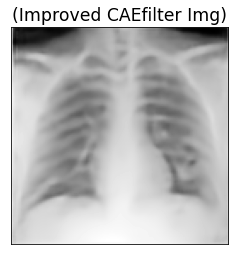

In [47]:
ax = plt.subplot()
plt.imshow(cae_x_test_sp_noisy[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Improved CAEfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

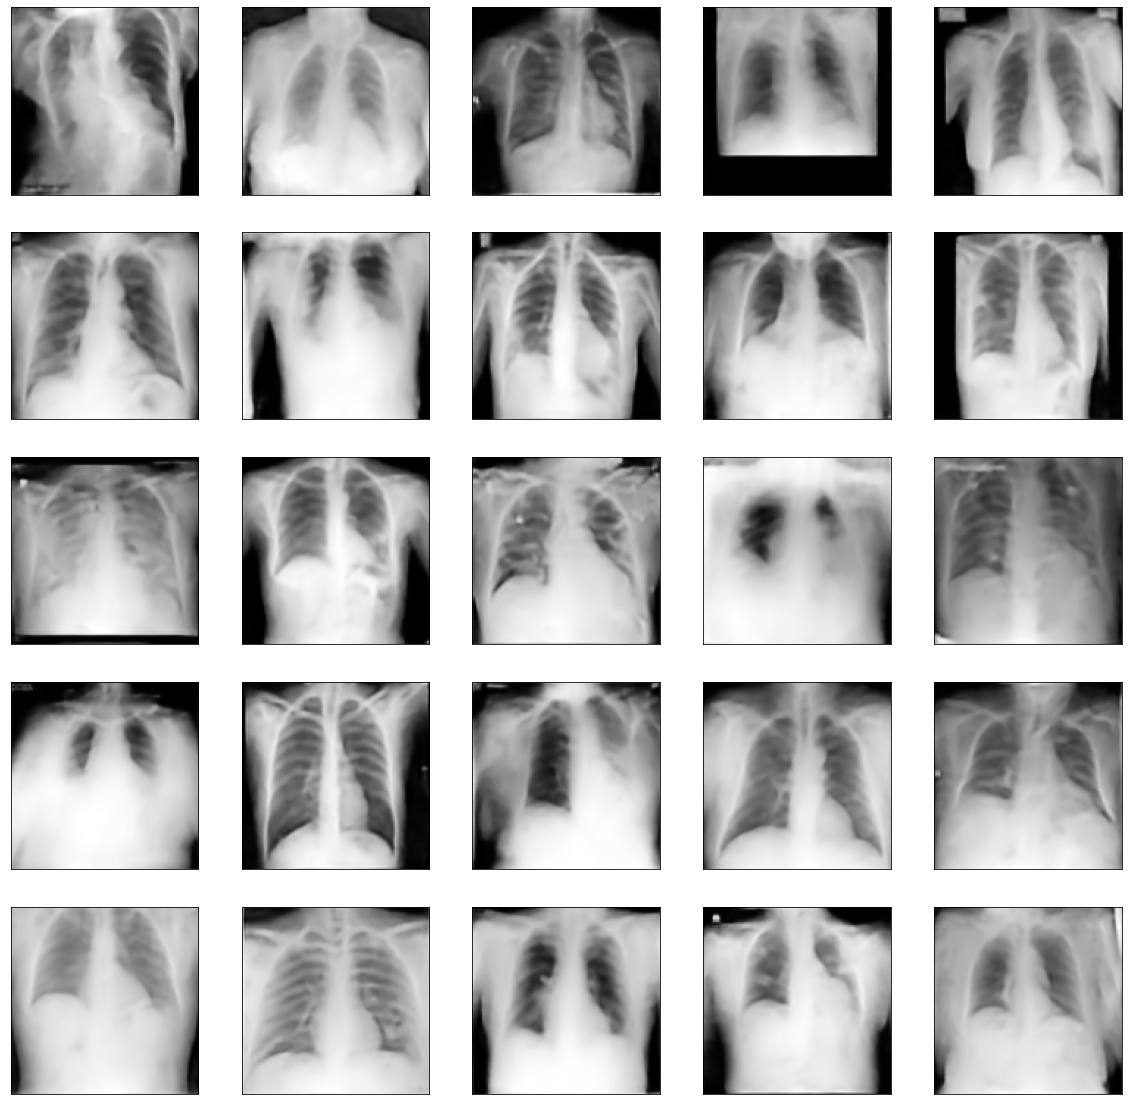

In [48]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(cae_x_test_sp_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [49]:
data = pd.read_csv("./csv/de_cdae_gauss_42.csv")
data

,Unnamed: 0,loss,PSNR1,SSIM1,val_loss,val_PSNR1,val_SSIM1
0,0,0.007894,24.251158,0.758339,0.001692,28.211775,0.818343
1,1,0.001573,28.490860,0.825009,0.001357,29.135958,0.831445
2,2,0.001361,29.080563,0.834257,0.001221,29.581020,0.838740
3,3,0.001224,29.502745,0.840949,0.001146,29.796358,0.844431
4,4,0.001132,29.809469,0.846500,0.001073,30.001200,0.849388
...,...,...,...,...,...,...,...
95,95,0.000645,32.119549,0.884036,0.000698,31.764366,0.883529
96,96,0.000644,32.129505,0.884177,0.000662,32.000965,0.883893
97,97,0.000645,32.122059,0.884238,0.000655,32.047939,0.883835
98,98,0.000639,32.164700,0.884422,0.000640,32.161114,0.884763


In [50]:
cae_loss = data['loss'].tolist()
cae_val_loss = data['val_loss'].tolist()

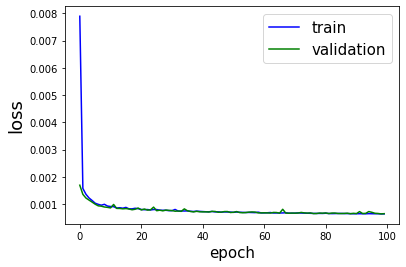

In [55]:
#cae_loss = autoencodersp_train.history['loss']
#cae_val_loss = autoencodersp_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, cae_loss, 'b', label="train")

plt.plot(epochs, cae_val_loss, 'g', label="validation")
plt.xlabel("epoch",fontsize=15)
plt.ylabel("loss",fontsize=18)
plt.rc('xtick', labelsize=13)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=12)  # y축 눈금 폰트 크기
plt.legend()
plt.legend(fontsize=15)
plt.show()

In [53]:
#cae_loss = autoencodersp_train.history['loss']
#cae_val_loss = autoencodersp_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, cae_loss, 'b', label="train")
plt.plot(epochs, cae_val_loss, 'g', label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

NameError: name 'autoencodersp_train' is not defined

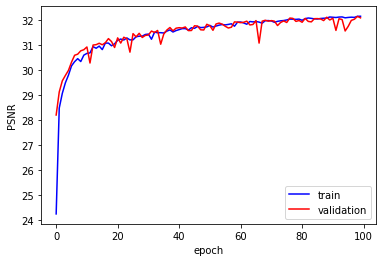

In [50]:
cae_loss = autoencodersp_train.history['PSNR1']
cae_val_loss = autoencodersp_train.history['val_PSNR1']
epochs = range(100)
plt.figure()
plt.plot(epochs, cae_loss, 'b', label="train")
plt.plot(epochs, cae_val_loss, 'r', label="validation")
plt.xlabel("epoch")
plt.ylabel("PSNR")
plt.legend()
plt.show()

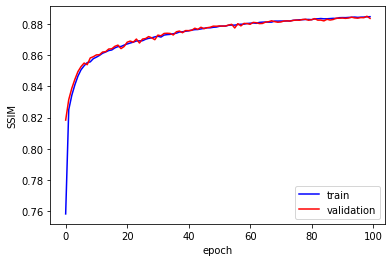

In [51]:
cae_loss = autoencodersp_train.history['SSIM1']
cae_val_loss = autoencodersp_train.history['val_SSIM1']
epochs = range(100)
plt.figure()
plt.plot(epochs, cae_loss, 'b', label="train")
plt.plot(epochs, cae_val_loss, 'r', label="validation")
plt.xlabel("epoch")
plt.ylabel("SSIM")
plt.legend()
plt.show()

In [52]:
from skimage.metrics import structural_similarity as ssim

In [53]:
cae_x_test_sp_noisy = cae_x_test_sp_noisy.numpy()

In [56]:
psnr_mean = []
mae_mean = []
psnr_median = []
mae_median = []
# psnr_nlmeans = []
# mae_nlmeans = []
# psnr_bilateral = []
# mae_bilateral = []
# psnr_wavelet = []
# mae_wavelet = []

psnr_cae = []
mae_cae = []



ssim_mean=[]
ssim_median=[]
# ssim_nlmeans=[]
# ssim_bilateral=[]
# ssim_wavelet=[]
ssim_cae=[]

for i in range(len(x_test_sp_noisy)):
    mae_mean.append(MAE(mean_x_test_sp_noisy[i],x_test[i]))
    mae_median.append(MAE(median_x_test_sp_noisy[i],x_test[i]))
#     mae_nlmeans.append(MAE(nlmeans_x_test_sp_noisy[i],x_test[i]))
#     mae_bilateral.append(MAE(bilateral_x_test_sp_noisy[i],x_test[i]))  
    mae_cae.append(MAE(cae_x_test_sp_noisy[i],x_test[i]))
    
    psnr_mean.append(PSNR(mean_x_test_sp_noisy[i],x_test[i]))
    psnr_median.append(PSNR(median_x_test_sp_noisy[i],x_test[i]))
#     psnr_nlmeans.append(PSNR(nlmeans_x_test_sp_noisy[i],x_test[i]))
#     psnr_bilateral.append(PSNR(bilateral_x_test_sp_noisy[i],x_test[i]))
    
    psnr_cae.append(PSNR(cae_x_test_sp_noisy[i],x_test[i]))
    
    ssim_mean.append(ssim(x_test[i], mean_x_test_sp_noisy[i]))
    ssim_median.append(ssim(x_test[i], median_x_test_sp_noisy[i]))
#     ssim_nlmeans.append(ssim(x_test[i], nlmeans_x_test_sp_noisy[i]))
#     ssim_bilateral.append(ssim(x_test[i], bilateral_x_test_sp_noisy[i]))
    
    ssim_cae.append(ssim(x_test[i], cae_x_test_sp_noisy[i]))

C:\Users\User\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [57]:
print("About Gauss Noisy")
print("Mean Filter : MAE = " +  str(np.mean(mae_mean)) + " & PSNR = " + str(np.mean(psnr_mean))+" & SSIM = "+str(np.mean(ssim_mean)))
print("Median Filter : MAE = " +  str(np.mean(mae_median)) + " & PSNR = " + str(np.mean(psnr_median))+" & SSIM = "+str(np.mean(ssim_median)))
#print("Bilateral Filter : MAE = " +  str(np.mean(mae_bilateral)) + " & PSNR = " + str(np.mean(psnr_bilateral))+" & SSIM = "+str(np.mean(ssim_bilateral)))
#print("NL Means Filter : MAE = " +  str(np.mean(mae_nlmeans)) + " & PSNR = " + str(np.mean(psnr_nlmeans))+" & SSIM = "+str(np.mean(ssim_nlmeans)))
#print("Wavelet Filter : MAE = " +  str(np.mean(mae_wavelet)) + " & PSNR = " + str(np.mean(psnr_wavelet))+" & SSIM = "+str(np.mean(ssim_wavelet)))
print("De_CAE Filter : MAE = " +  str(np.mean(mae_cae)) + " & PSNR = " + str(np.mean(psnr_cae))+" & SSIM = "+str(np.mean(ssim_cae)))


About Gauss Noisy
Mean Filter : MAE = 0.03037000065560521 & PSNR = 28.11556948367694 & SSIM = 0.8408436405800095
Median Filter : MAE = 0.035166092821897005 & PSNR = 26.66803531666919 & SSIM = 0.79193672652751
De_CAE Filter : MAE = 0.01810112947119854 & PSNR = 32.097548515248 & SSIM = 0.9414469150865103
